# Traveling salesman problem

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
letters = [f'{chr(i)}' for i in range(65, 65 + 26)] + [f'{chr(i)}*' for i in range(65, 65 + 26)]

In [3]:
class City:
    def __init__(self, coord, number):
        self.x = coord[0]
        self.y = coord[1]
        self.name = letters[number]
        
    def distance(self, city):
        return np.sqrt((self.x - city.x) ** 2 + (self.y - city.y) ** 2)
    
    def __repr__(self):
        return f'{self.name}: ({str(self.x)}; {self.y})'

In [77]:
def map_city(cities_num, cities_range):
    return [City(np.random.randint(1, cities_range, size=2), j) for j in range(cities_num)]

In [232]:
np.random.seed(13)
not_closed_road = map_city(52, 2000)

In [233]:
closed_road = not_closed_road + [not_closed_road[0]]

In [234]:
def total_distance(path, cities_lst): # тождественно нашей целевой функции
    dist_lst = []
    for j in range(len(path) - 1):
        dist_lst.append(cities_lst[j].distance(cities_lst[j + 1]))
    dist_lst.append(cities_lst[j + 1].distance(cities_lst[0]))
    return sum(dist_lst)

In [235]:
path = [city.name for city in closed_road]

In [236]:
route_dist = total_distance(path=path, cities_lst=closed_road)

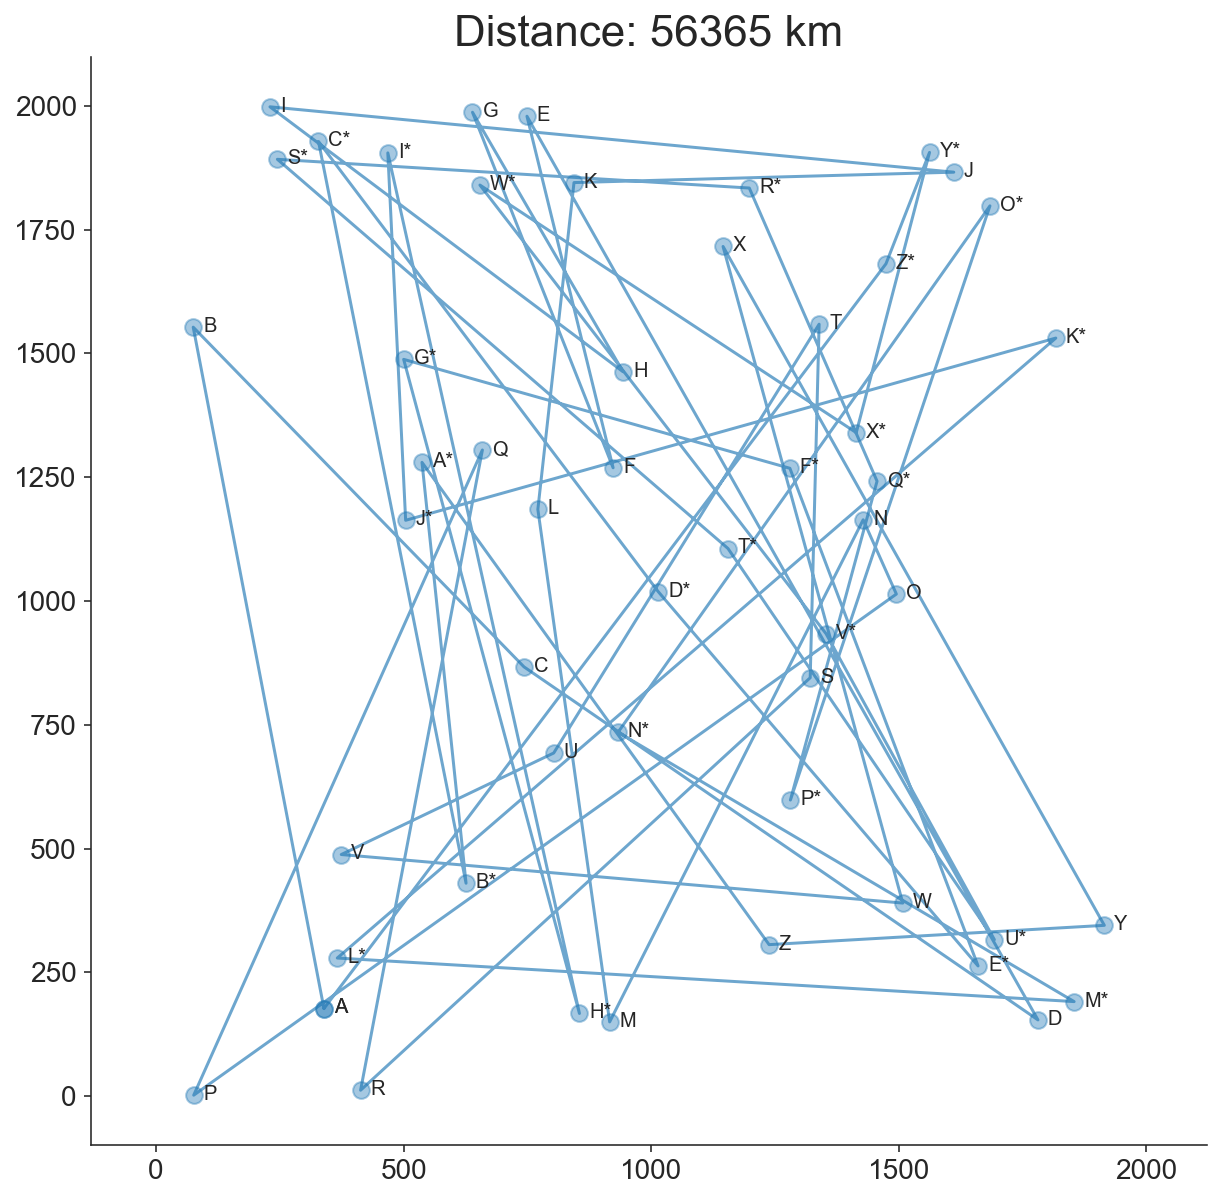

In [237]:
fig = plt.figure(figsize=(10,10))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title(f'Distance: {int(round(route_dist))} km', fontsize=22)
plt.plot([city.x for city in closed_road],
         [city.y for city in closed_road], alpha=0.65)
plt.scatter([city.x for city in closed_road], 
            [city.y for city in closed_road], s=70, marker='o', alpha=0.4)

for j in range(len(closed_road)):
    plt.text(closed_road[j].x + 20, closed_road[j].y - 10,  closed_road[j].name)
    
plt.axis("equal")
sns.set_style("white")

In [238]:
fig.savefig("TSP1.png", bbox_inches='tight', dpi=600)

In [207]:
class Individual:
    def __init__(self, cities_lst, id_of_individual):
        self.map = random.sample(cities_lst[:-1], len(cities_lst[:-1]))
        self.path = [city.name for city in self.map]
        self.id_of_individual = id_of_individual
        self.dist = None
        self.fitness = None
        
    def __repr__(self):
        return f'Individual {self.id_of_individual}: Distance = {int(round(self.dist))} km'

In [208]:
class GeneticAlgorithm:
    def __init__(self, ell, k, mutation_rate, inital_map, max_iter):
        """
        PARAMETERS:
        ell --- количество особей в поколении
        k --- количество особей для размножения
        mutation_rate --- коэффициент мутации
        max_iter --- максимальное количество эволюций поколения (новых поколений)
        """
        self.ell = ell
        self.k = k
        self.mutation_rate = mutation_rate
        self.inital_map = inital_map
        self.max_iter = max_iter
        
        self.best_individuals = None # k наиболее приспособленных особей
        self.fittest_indivdual = None # самая приспособленная особь
        self.population = None
        self.best_target_value_history = []
        
    def search_best_path(self):
        # создаем первое поколение
        self.population = self.create_population()
    
        # проходим этапы эволюции
        for i in tqdm(range(self.max_iter)):
            # оцениваем приспособленность наших особей
            self.evaluate_population()
            # отбираем k наиболее наиболее приспособленных особей
            self.selection()
            self.best_target_value_history.append(self.fittest_indivdual.dist)
            
            # формируем новые поколения
            # скрещиваем особи
            for idx in range(self.k, self.ell):
                # случайно выбираем одну из наилучших особей
                select_fitted_individual = np.random.choice(self.best_individuals)
                # создаем потомка и заменяем им старую особь
                offspring = self.crossover(select_fitted_individual,
                                           self.population[idx])
                self.population[idx].map = offspring
            
            # мутируем все особи, кроме самой приспособленной
            for individual in self.population[1:]:
                self.mutate(individual)
                
        return self.fittest_indivdual

    def create_population(self):
        return [Individual(self.inital_map, i + 1) for i in range(self.ell)]
    
    def evaluate_population(self):
        F = []
        
        for individual in self.population:
            individual.dist = total_distance(individual.path + [individual.path[0]],
                                             individual.map + [individual.map[0]])
            F.append(individual.dist)
        
        for individual in self.population:
            individual.fitness = self.normalize(individual.dist,
                                                min(F), max(F))
            
    def normalize(self, z, F_best, F_worst):
        """
        INPUT:
        z --- масштабируемое значение
        F_best --- лучшее значение целевой функции
        F_worst --- худшее значение целевой функции
        """
        return (z - F_worst) / (F_best - F_worst)
    
    def selection(self):
        """
        Оператор отбора
        """
        self.population = sorted(self.population,
                                 key=lambda individual: individual.fitness, reverse=True)
        self.best_individuals = self.population[:self.k]
        self.fittest_indivdual = self.population[0]
    
    def crossover(self, parent_fitted, parent_random):
        """
        Оператор скрещивания
        
        INPUT:
        parent_fitted --- одна из самых приспособленных особей
        parent_random --- случайная особь
        """
        genes_1 = int(np.random.uniform(0, 1) * len(parent_fitted.path))
        genes_2 = int(np.random.uniform(0, 1) * len(parent_fitted.path))
        
        start = min(genes_1, genes_2)
        end = max(genes_1, genes_2)
        
        if (end - start > self.ell / 2) and (np.random.uniform(0, 1) < parent_fitted.fitness):
            offspring_1 = parent_fitted.map[start:end]
            offspring_2 = [city for city in parent_random.map if city not in offspring_1]
        else:
            offspring_1 = parent_random.map[start:end]
            offspring_2 = [city for city in parent_fitted.map if city not in offspring_1]
    
        return offspring_1 + offspring_2
    
    def mutate(self, individual):
        """
        Оператор мутации
    
        INPUT:
        individual --- особь, подвергающаяся мутации
        """
        for j in range(len(individual.path)):
            if np.random.uniform(0, 1) < self.mutation_rate:
                num = np.random.randint(len(individual.path))
                individual.map[j], individual.map[num] = individual.map[num], individual.map[j]        

In [226]:
a = GeneticAlgorithm(ell=1500, k=300, mutation_rate=0.001, inital_map=closed_road, max_iter=1500)

In [227]:
a.search_best_path()

100%|██████████| 1500/1500 [29:50<00:00,  1.19s/it] 


In [252]:
a.fittest_indivdual

Individual 658: Distance = 11486 km

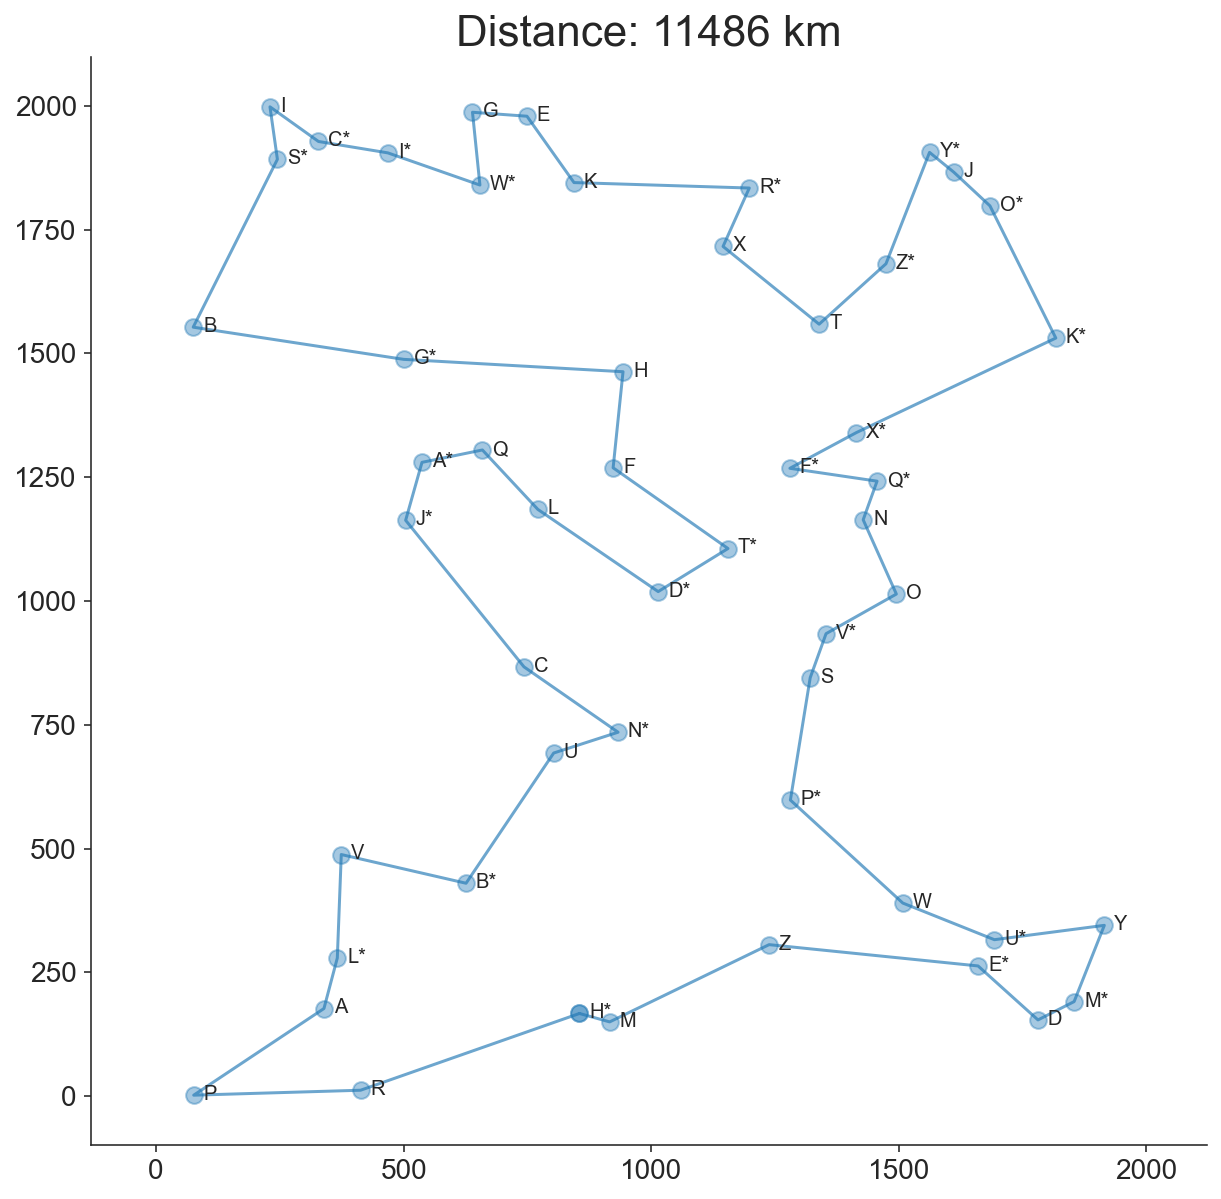

In [239]:
fig = plt.figure(figsize=(10,10))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title(f'Distance: {int(round(a.fittest_indivdual.dist))} km', fontsize=22)
plt.plot([city.x for city in ans],
         [city.y for city in ans], alpha=0.65)
plt.scatter([city.x for city in ans], 
            [city.y for city in ans], s=70, marker='o', alpha=0.4)

for j in range(len(a.fittest_indivdual.map)):
    plt.text(a.fittest_indivdual.map[j].x + 20, a.fittest_indivdual.map[j].y - 10, a.fittest_indivdual.map[j].name)
    
plt.axis("equal")
sns.set_style("white")

In [240]:
fig.savefig("TSP2.png", bbox_inches='tight', dpi=600)

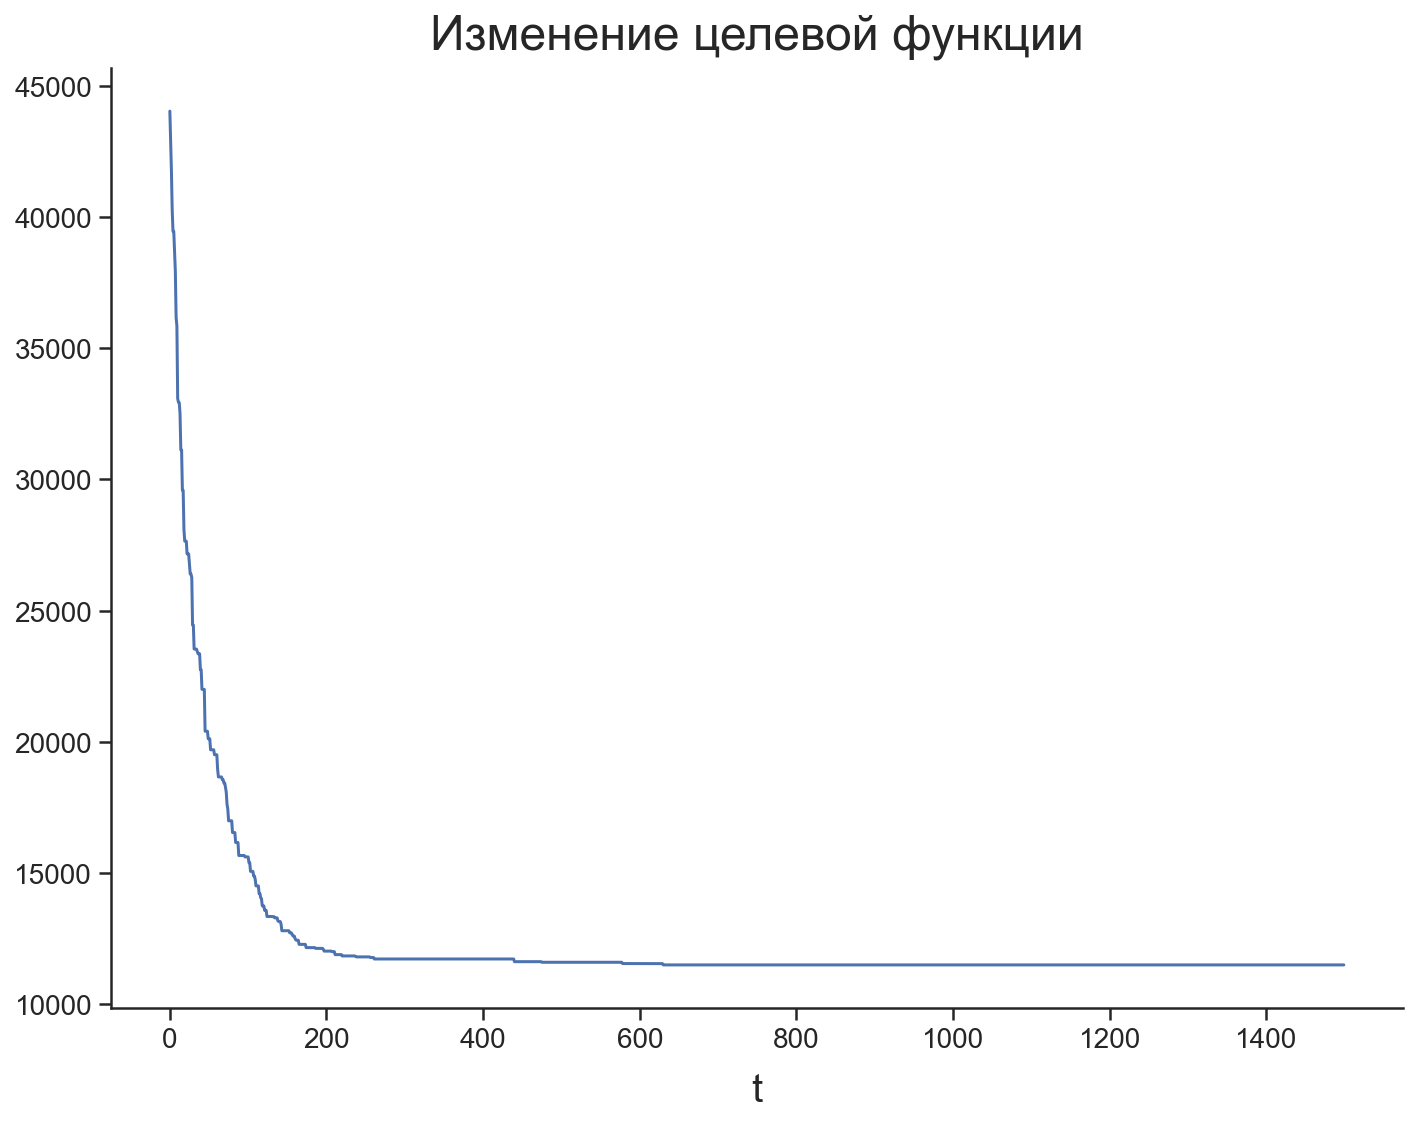

In [250]:
fig = plt.figure(figsize=(10, 8))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.xlabel("t", fontsize=20, labelpad=10)  
plt.title("Изменение целевой функции", fontsize=24, pad=10) 
plt.plot(a.best_target_value_history)

fig.tight_layout()

In [251]:
fig.savefig("TSP3.png", bbox_inches='tight', dpi=600)